# Project1-ResNet_Ablation_Study

#### 목표

1) ResNet-34, ResNet-50 모델 구현해보기 <br/>
2) 구현한 ResNet을 통한 Image Classification 모델 훈련 <br/>
3) Ablation Study 결과 만들어보기 <br/>







# ResNet VS Plain 모델 구현해보기
---

> ResNet의 기본 아이디어는 여러 레이어를 걸친 입력 뿐 아니라 그 전의 입력값도 더하여 넣어준다는 것이다.

![스크린샷, 2021-04-20 22-32-37](https://user-images.githubusercontent.com/70703320/115404535-6150aa00-a228-11eb-9783-8aa95db81450.png)
\[출처: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.\]

> ResNet을 이용하였을 때와 이용하지 않았을 때 다음과 같은 구조의 차이를 확인해보자.

![스크린샷, 2021-04-20 22-31-15](https://user-images.githubusercontent.com/70703320/115404845-a96fcc80-a228-11eb-8ac8-f8628af65871.png)
\[출처: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.\]

이제 위 그림을 참조한 논문 [Deep Residual Learning for Image Recognition](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)을 참조하여 ResNet 34, 50과 Plain 34, 50 모델을 만들어서 이들의 성능을 비교해보자.


#### 라이브러리 실행

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# graphviz로 시각화 하기
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

## 1.  ResNet 레이어 구성하기

![스크린샷, 2021-04-20 22-30-44](https://user-images.githubusercontent.com/70703320/115405388-27cc6e80-a229-11eb-868f-ecc6ca79bf60.png)

\[출처: He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.\]


### 1) ResNet 34

#### ResNet 34 Block 구성

In [2]:
def ResNet34_Block(input_layer,
                 channel=64,
#                  stage_num=1,
                 first=False):
    
    # 입력 레이어
    x = input_layer
    
    if not first:
    
        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(x)

        # Add
        x = keras.layers.Add()([input_layer, x])

        # Activation
        x = keras.layers.Activation('relu')(x)
    
    else:
        
        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            strides=2,
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)        
                
        # Conv2D
        y = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            strides=2,
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(input_layer)

        # Batch Normalization 
        y = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(y)

        # Add
        x = keras.layers.Add()([x, y])

        # Activation
        x = keras.layers.Activation('relu')(x)        
    
    return x

#### ResNet 34 구성

In [3]:
def resnet_34(input_shape=(32,32,3),
              channel_list=[64,64,64,128,128,128,128,256,256,256,256,256,256,512,512,512],
              first_list=[False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False],
              num_classes=2):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
        

    # Conv1
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        kernel_initializer='he_normal',
        padding='same'
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2
    )(x)


    
    for i, (channel, first) in enumerate(zip(channel_list, first_list)): 
        x = ResNet34_Block(
            x,
            channel=channel,
            first = first
        )
    
    output = keras.layers.AveragePooling2D(
             pool_size=(2, 2),
             strides=2,
             padding='same'
             
    )(x)
    
    
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    
    model = keras.Model(
            inputs = input_layer,
            outputs = output)

    
    return model

### 2) Plain 34 

#### Plain 34 Block 

In [4]:
def plain_34_Block(input_layer,
                   num_cnn=2, 
                   channel=64,
                   block_num=1,
                   stride=1
                   ):
    # 입력 레이어
    x = input_layer
    
    for cnn_num in range(num_cnn):
        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same',
            strides=stride,
            name=f'block{block_num}_conv{cnn_num}'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_batch{cnn_num}'
        )(x)

        # Activation
        x = keras.layers.Activation('relu',
            name=f'block{block_num}_act{cnn_num}'
        )(x)
        
    return x


#### Plain34 구성

In [5]:
def plain_34(input_shape=(32,32,3),
             num_cnn_list=[3,4,6,3],
             channel_list=[64,128,256,512],
             num_classes=2,
             stride=1
             ):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
        

    # Conv1
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        kernel_initializer='he_normal',
        padding='same'
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2
    )(x)


    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)): 
        
        if i == 1:
            stride=2
        else:
            stride=1
                
        x = plain_34_Block(
            x,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            stride=stride
        )

        
    output = keras.layers.AveragePooling2D(
             pool_size=(2, 2),
             strides=2,
             padding='same'
             
    )(x)
    
    
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    
    model = keras.Model(
            inputs = input_layer,
            outputs = output)

    
    return model

## 2. 50 layer 구성하기

### 1) ResNet 50 구성

#### ResNet 50 Block 구성

In [6]:
def ResNet50_Block(input_layer,
                 channel=64,
#                  stage_num=1,
                 first=False):
    
    # 입력 레이어
    x = input_layer
    
    if not first:
    
        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)        

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(x)
        
        # Add
        x = keras.layers.Add()([x, input_layer])

        # Activation
        x = keras.layers.Activation('relu')(x)
    
    else:
        
        if channel == 64: 
            stride=1 
        else: 
            stride=2
            # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            strides=stride,
            kernel_initializer='he_normal',
            padding='same'
#           name=f'stage{stage_num}_conv1'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)        

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(x)

        # Conv2D
        y = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            strides=stride,
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(input_layer)

        # Batch Normalization 
        y = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(y)

        # Add
        x = keras.layers.Add()([x, y])

        # Activation
        x = keras.layers.Activation('relu')(x)      
    
    return x

#### ResNet 50 구성

In [7]:
def resnet_50(input_shape=(32,32,3),
              channel_list=[64,64,64,128,128,128,128,256,256,256,256,256,256,512,512,512],
              first_list=[True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False],
              num_classes=2):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
        

    # Conv1
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        kernel_initializer='he_normal',
        padding='same'
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2
    )(x)
    
    
    for i, (channel, first) in enumerate(zip(channel_list, first_list)): 
        x = ResNet50_Block(
            x,
            channel=channel,
            first = first
        )

        
    output = keras.layers.AveragePooling2D(
             pool_size=(2, 2),
             strides=2,
             padding='same'
             
    )(x)
    
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    
    model = keras.Model(
            inputs = input_layer,
            outputs = output)
    

    
    return model

### 2) Plain 50 구성

#### Plain 50 Block 구성하기

In [8]:
def plain50_Block(input_layer,
                 channel=64,
#                  stage_num=1,
                 first=False):
    
    # 입력 레이어
    x = input_layer
    
    if not first:
    
        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)
    
        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)        

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)
    
    else:
        
        if channel == 64: 
            stride=1 
        else: 
            stride=2
            # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            strides=stride,
            kernel_initializer='he_normal',
            padding='same'
#           name=f'stage{stage_num}_conv1'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv1'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch1'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)        

        # Conv2D
        x = keras.layers.Conv2D(
            filters=channel*4,
            kernel_size=(1,1),
            kernel_initializer='he_normal',
            padding='same'
#             name=f'stage{stage_num}_conv2'
        )(x)

        # Batch Normalization 
        x = keras.layers.BatchNormalization(
#             name=f'stage{stage_num}_batch2'
        )(x)

        # Activation
        x = keras.layers.Activation('relu')(x)      
    
    return x

#### Plain 50 함수 구성

In [9]:
def plain_50(input_shape=(32,32,3),
             channel_list=[64,64,64,128,128,128,128,256,256,256,256,256,256,512,512,512],
             first_list=[True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False],
             num_classes=2):
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
        

    # Conv1
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        strides=2,
        kernel_initializer='he_normal',
        padding='same'
    )(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = keras.layers.MaxPooling2D(
             pool_size=(2, 2),
             strides=2
    )(x)


    
    for i, (channel, first) in enumerate(zip(channel_list, first_list)): 
        x = plain50_Block(
            x,
            channel=channel,
            first = first
        )

        
    output = keras.layers.AveragePooling2D(
             pool_size=(2, 2),
             strides=2,
             padding='same'
             
    )(x)
    
    
    output = keras.layers.Flatten()(output)
    output = keras.layers.Dense(num_classes, activation='softmax')(output)

    
    model = keras.Model(
            inputs = input_layer,
            outputs = output)

    
    return model

# 최종 ResNet, Plain 함수 사용하기
---
### build_resnet 함수 정의

In [10]:
def build_resnet(input_shape=(224,224,3),
                 is_50=False):       
   
    if not is_50:
        model = resnet_34(input_shape)
        
    
    else:
        model = resnet_50(input_shape)
    
    return model

#### build_resnet 함수로 ResNet 34 만들기

In [11]:
resnet_34 = build_resnet(is_50=False)

resnet_34.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### build_resnet 함수로 ResNet 50 만들기

In [12]:
resnet_50 = build_resnet(is_50=True)

resnet_50.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

### build_plain 함수 정의

In [13]:
def build_plain(input_shape=(224,224,3),
                is_50=False):       
   
    if not is_50:
        model = plain_34(input_shape)
        
    
    else:
        model = plain_50(input_shape)
    
    return model

#### build_plain 함수로 plain 34 함수 만들기

In [14]:
plain_34 = build_plain(is_50=False)

plain_34.summary() 

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block0_batch0 (BatchNormaliz (None, 56, 56, 64)        256 

#### build_plain 함수로 plain 50 함수 만들기

In [15]:
plain_50 = build_plain(is_50=True)

plain_50.summary() 

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_90 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_83 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_91 (Batc (None, 56, 56, 64)        256 

# 데이터 불러오기
---
#### cats_vs_dogs

In [16]:
import urllib3
urllib3.disable_warnings()
dataset_name = 'cats_vs_dogs'
ds_train, ds_info_train = tfds.load(name=dataset_name, split='train[:80%]', as_supervised=True, with_info=True)
ds_valid, ds_info_valid = tfds.load(name=dataset_name, split='train[80%:]', as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


#### 전처리 함수

In [17]:
def preprocess(features):
    print(features['image'], features['label'])
    image = tf.image.resize(features['image'], [224,224])
    image = tf.divide(image, 255)
    print(image)
    label = features['label']
    print(label)
    return image, tf.cast(label, tf.float32)

#### normalize와 resize함수

In [18]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

#### 전체 적용하는 함수

In [19]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [20]:
print(ds_info_train.features)
print(ds_info_valid.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


#### 하이퍼 파라미터 조정 (batch_size, epoch)

In [21]:
BATCH_SIZE = 64
EPOCH = 20

#### train와 valid에 normalize 적용

In [22]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_valid = apply_normalize_on_dataset(ds_valid, batch_size=BATCH_SIZE)

#### resnet_34

In [23]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 269s 817ms/step - loss: 0.8770 - accuracy: 0.5433 - val_loss: 0.7175 - val_accuracy: 0.6040
Epoch 2/20
290/290 [==============================] - 218s 753ms/step - loss: 0.7179 - accuracy: 0.6369 - val_loss: 0.8034 - val_accuracy: 0.5959
Epoch 3/20
290/290 [==============================] - 219s 754ms/step - loss: 0.6210 - accuracy: 0.6913 - val_loss: 0.7412 - val_accuracy: 0.6358
Epoch 4/20
290/290 [==============================] - 219s 756ms/step - loss: 0.5427 - accuracy: 0.7295 - val_loss: 0.7095 - val_accuracy: 0.6524
Epoch 5/20
290/290 [==============================] - 219s 756ms/step - loss: 0.4862 - accuracy: 0.7650 - val_loss: 0.6775 - val_accuracy: 0.6856
Epoch 6/20
290/290 [==============================] - 219s 755ms/step - loss: 0.4017 - accuracy: 0.8164 - val_loss: 0.6985 - val_accuracy: 0.7071
Epoch 7/20
290/290 [==============================] - 219s 755ms/step - loss: 0.3004 - accuracy: 0.8687 - val_loss: 0.7018 -

#### resnet_50

In [24]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_r50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 458s 1s/step - loss: 0.9946 - accuracy: 0.5261 - val_loss: 0.9740 - val_accuracy: 0.4941
Epoch 2/20
290/290 [==============================] - 403s 1s/step - loss: 0.9090 - accuracy: 0.5518 - val_loss: 0.9214 - val_accuracy: 0.5625
Epoch 3/20
290/290 [==============================] - 411s 1s/step - loss: 0.8976 - accuracy: 0.5595 - val_loss: 0.8965 - val_accuracy: 0.5538
Epoch 4/20
290/290 [==============================] - 403s 1s/step - loss: 0.8346 - accuracy: 0.5851 - val_loss: 1.1927 - val_accuracy: 0.5619
Epoch 5/20
290/290 [==============================] - 403s 1s/step - loss: 0.7913 - accuracy: 0.5990 - val_loss: 0.8133 - val_accuracy: 0.6090
Epoch 6/20
290/290 [==============================] - 591s 2s/step - loss: 0.7725 - accuracy: 0.6183 - val_loss: 1.1054 - val_accuracy: 0.5929
Epoch 7/20
290/290 [==============================] - 561s 2s/step - loss: 0.7702 - accuracy: 0.6166 - val_loss: 0.9142 - val_accuracy: 0.5715

#### plain_34

In [25]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 118s 331ms/step - loss: 0.7016 - accuracy: 0.5496 - val_loss: 0.7501 - val_accuracy: 0.5026
Epoch 2/20
290/290 [==============================] - 90s 311ms/step - loss: 0.6368 - accuracy: 0.6458 - val_loss: 0.6845 - val_accuracy: 0.6009
Epoch 3/20
290/290 [==============================] - 86s 298ms/step - loss: 0.5867 - accuracy: 0.6809 - val_loss: 0.6489 - val_accuracy: 0.6330
Epoch 4/20
290/290 [==============================] - 87s 299ms/step - loss: 0.5372 - accuracy: 0.7279 - val_loss: 0.6627 - val_accuracy: 0.6497
Epoch 5/20
290/290 [==============================] - 87s 299ms/step - loss: 0.4309 - accuracy: 0.8039 - val_loss: 0.7293 - val_accuracy: 0.6445
Epoch 6/20
290/290 [==============================] - 87s 299ms/step - loss: 0.3063 - accuracy: 0.8784 - val_loss: 0.9643 - val_accuracy: 0.6250
Epoch 7/20
290/290 [==============================] - 86s 298ms/step - loss: 0.1692 - accuracy: 0.9395 - val_loss: 1.0709 - val_a

#### plain_50

In [26]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_p50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info_train.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info_valid.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
290/290 [==============================] - 356s 1s/step - loss: 0.7434 - accuracy: 0.5283 - val_loss: 0.7344 - val_accuracy: 0.4946
Epoch 2/20
290/290 [==============================] - 338s 1s/step - loss: 0.7457 - accuracy: 0.5114 - val_loss: 1.0603 - val_accuracy: 0.5139
Epoch 3/20
290/290 [==============================] - 338s 1s/step - loss: 0.7487 - accuracy: 0.5111 - val_loss: 1.0321 - val_accuracy: 0.5076
Epoch 4/20
290/290 [==============================] - 339s 1s/step - loss: 0.7484 - accuracy: 0.5193 - val_loss: 0.7748 - val_accuracy: 0.5321
Epoch 5/20
290/290 [==============================] - 338s 1s/step - loss: 0.7387 - accuracy: 0.5150 - val_loss: 0.8606 - val_accuracy: 0.5174
Epoch 6/20
290/290 [==============================] - 338s 1s/step - loss: 0.7418 - accuracy: 0.5117 - val_loss: 0.7809 - val_accuracy: 0.5096
Epoch 7/20
290/290 [==============================] - 339s 1s/step - loss: 0.7432 - accuracy: 0.5120 - val_loss: 0.7883 - val_accuracy: 0.4983

## 모델별 성능 시각화

#### loss graph

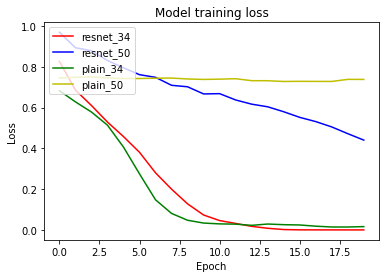

In [27]:
import matplotlib.pyplot as plt

plt.plot(history_r34.history['loss'], 'r')
plt.plot(history_r50.history['loss'], 'b')
plt.plot(history_p34.history['loss'], 'g')
plt.plot(history_p50.history['loss'], 'y')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

#### accuracy graph

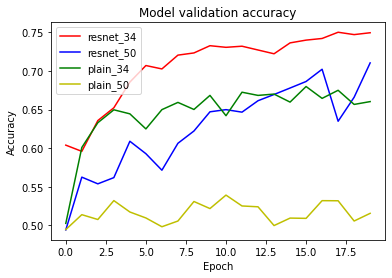

In [28]:
plt.plot(history_r34.history['val_accuracy'], 'r')
plt.plot(history_r50.history['val_accuracy'], 'b')
plt.plot(history_p34.history['val_accuracy'], 'g')
plt.plot(history_p50.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'resnet_50', 'plain_34', 'plain_50'], loc='upper left')
plt.show()

## 회고
---

- 논문만을 참조하여 모델을 구현해보는 어려움
> - 처음으로 논문만을 보고 모델을 구현해보아서 인지 가장 많은 시간이 소요되었고 난이도도 지금까지의 어떤 것보다 어려웠다. 처음에는 함수를 쓰지 않고 레이어를 쌓는 방식을 사용하다가 레이어가 반복되는 부분을 찾고 반복될 때 다른 부분은 조건문으로 해결하여 함수를 만들었다. 한 번 ResNet34 만들고나니 자신감이 붙었고 이어서 ResNet50도 도전해볼 수 있었다. 
> - 가장 아쉬운 점은 레이어의 이름을 설정해주는 것은 너무 막막하여 넘어가기로 하였다. 이는 추후 평가가 끝난 뒤 더 공부를 하여 해결해보는 방안을 취해보도록 하겠다.


- tdfs의 데이터를 사용하는 것의 어려움
> - 지금까지는 외부 데이터를 사용하여 sklearn.model_selection에서 train_test_split이란 함수를 사용하여 train 데이터와 test 데이터를 나누었다. 하지만 이번엔 이 방법이 아닌 `tfds.load(name=dataset_name, split='train[:80%]', as_supervised=True, with_info=True)`과 같은 방식을 사용해야 한다는 것이 어려웠다. 

## 루브릭
---

- 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
> - 이를 위해 매우 많은 시도를 하였으며 (32, 32, 3)을 input으로 하였을 때 동일한 결과를 얻음을 확인하였다. 
    
    
- cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
> - 모델별 성능 시각화의 loss graph에서 확인이 가능하다.
    
  
- ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.

||ResNet-34|Plain-34|ResNet-50|Plain-50|
|:---:|:---:|:---:|:---:|:---:|
|accuracy|0.7496|0.6604|0.7105|0.5156|
